# Lab 3: Nearest Neighbor and Classification Competition

#### COSC 410: Spring 2024, Colgate University

The goal of this notebook is to strengthen your understanding of $k$ Nearest Neighbor classification and to expand on your familarity with a standard machine learning pipeline. First you'll implement a version of $k$-NN classification. Then, you'll explore a weather prediction data set. Finally, you'll implement a function for fitting a classification model of your choosing on this dataset. 

Here are some learning objectives for this lab: 

1. Implement $k$-NN classification
2. Explore a dataset and standardize the values
3. Generate some plots to investigate some initial hypotheses
4. Apply any classification model from sklearn that we've discussed in class (i.e. `Logisitic Regression`, `SVC`, or `KNearestNeighbors`)
5. Experience with leaderboards


| Part | Description                       | Code? | Response? | 
| ---- | --------------------------------- | ----- | --------- |
| 1    | Implement $k$-NN                  | Yes   |    No     |
| 2    | Preprocess data and explore       | Yes   |    Yes    |
| 3    | Apply a classifier to data        | Yes   |    No     | 

In [2]:
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.linear_model import LogisticRegression

## Part 1: $k$-NN

In [3]:
def euclidean_distance(point: np.array, data: np.array) -> np.array:
    """ Calculates the euclidean distance for a point against all the data.

    Args:
        point (np.array): A single sample from test data
        data (np.array): All of the train data to calculate the distance for
    Returns:
        np.array: Distances between the point and all the data
    """
    distances = np.sqrt(np.sum((data - point) ** 2, axis = 1))
    return distances

In [4]:
def mode(labels: list): 
    """ Returns the mode value from a list 

    Args:
        labels (list): A list of labels (e.g., ['cat', 'dog', 'cat'], [1, 0, 0], etc.)
    Returns:
        The mode (e.g., 'cat', 0, etc.)
    """ 
    count = Counter(labels)
    mode_label = count.most_common(1)[0][0]
    return mode_label

In [5]:
class KNN():
    """ K Nearest Neighbors Classifier 

    Attributes:

        k (int): How many neighbors to consider (default: 5)
        dist_func (Callable): Distance function (default: euclidean_distance)
        X (np.array): Input training data
        Y (np.array): Output (e.g., gold prediction) training data
    """
    def __init__(self, k:int=5, dist_func=euclidean_distance):
        self.k = k
        self.dist_func = dist_func

    def fit(self, X, Y):
        """ Adds X and Y from train to class """ 
        self.X = X
        self.Y = Y

    def predict(self, X_test: np.array) -> np.array:
        """ Makes prediction based on k closest neighbors

        Args:
            X_test (np.array): Input test data

        Returns:
            np.array: Predictions
        """ 
        predictions = []
        for val in X_test:
            dists = self.dist_func(val, self.X)
            closest_indices = np.argsort(dists)[:self.k]
            labels = self.Y[closest_indices]
            prediction = mode(labels)
            predictions.append(prediction)
        return np.array(predictions)


In [6]:
random_seed = 2323

np.random.seed(random_seed)
random.seed(random_seed)

classifier = KNN()

# Create data
X, Y = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)

# Split off a valid set
n = X.shape[0]
X_train = X[0:int(n*0.8)]
Y_train = Y[0:int(n*0.8)]
X_val = X[int(n*0.8):]
Y_val = Y[int(n*0.8):]
# Y_val is [1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1]


# Fit the classifier 
classifier.fit(X_train, Y_train)

# Get predictions
Y_pred = classifier.predict(X_val)
# Y_pred should be [1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0]

# Get metrics
precision = metrics.precision_score(Y_val, Y_pred)
recall = metrics.recall_score(Y_val, Y_pred)
f1 = metrics.f1_score(Y_val, Y_pred)
print(f"precision: {precision} recall: {recall} f1: {f1}")
# 1.0, 0.85714 0.923077

precision: 1.0 recall: 0.8571428571428571 f1: 0.923076923076923


## Part 2: Explore Dataset and Preprocessing

### ML Task Description

The `Lab3_train.csv` file contains 10 years worth of daily weather observations from locations
across Australia, one row per day. It contains a column registering a binary label for each observation (`RainTomorrow`) a `1` if it rained
on the following day or a `0` if it did not. Your goal will be to create a ML model that, when given a
new weather observations, can predict whether it will rain on the day after
the observation. In other words, can you use machine learning to predict if it will rain tomorrow
based on the weather today?

### Preprocessing

Your initial task is to preprocess this dataset. This includes resolving missing features, encoding nominal features, and appropriately scaling all features. You'll implement the function `preprocess`. Blocks below point out some useful tricks for approaching this.

In [7]:
df = pd.read_csv('Lab3_train.csv')

In [8]:
# Let's consider the first couple samples of our data
df.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,Sydney,18.6,25.3,0.0,4.2,4.5,NaN,NaN,SSE,ENE,...,24.0,70.0,59.0,1021.7,1019.4,7.0,6.0,21.2,23.8,0
1,MountGambier,4.0,12.4,4.0,0.4,2.5,WSW,46.0,SW,WSW,...,19.0,77.0,67.0,1011.0,1013.3,6.0,7.0,10.1,11.5,1
2,Wollongong,NaN,18.6,NaN,NaN,NaN,SSE,24.0,NaN,SW,...,7.0,NaN,87.0,1020.0,1018.5,NaN,8.0,NaN,16.5,1
3,Ballarat,4.9,11.2,0.4,NaN,NaN,SSE,26.0,SSW,SSE,...,15.0,100.0,96.0,1029.3,1028.4,8.0,8.0,7.9,10.2,0
4,Albury,6.2,10.0,21.4,NaN,NaN,NW,57.0,NW,NW,...,19.0,82.0,91.0,1009.2,1008.7,8.0,8.0,8.5,9.1,1
5,Sydney,10.1,20.7,0.0,4.0,8.5,W,44.0,W,WSW,...,22.0,61.0,37.0,1018.7,1014.7,4.0,3.0,11.3,19.6,0
6,Hobart,8.8,16.6,1.6,5.2,12.1,SW,65.0,W,SW,...,28.0,54.0,34.0,1013.1,1017.8,NaN,NaN,11.5,15.5,0
7,Perth,16.1,30.8,0.0,11.0,13.1,SW,39.0,E,SSW,...,22.0,44.0,30.0,1021.4,1017.7,0.0,0.0,21.8,29.2,0
8,SalmonGums,2.9,23.5,0.0,NaN,NaN,SSE,41.0,S,SSE,...,15.0,43.0,25.0,NaN,NaN,NaN,NaN,16.3,21.8,0
9,MountGinini,4.0,13.2,15.0,NaN,NaN,NaN,NaN,ENE,NaN,...,NaN,97.0,NaN,NaN,NaN,NaN,NaN,8.1,NaN,0


I hope you notice 3 things: 

1. There are some missing values. We see them as NaN in our table. For example, The location Wollongong has a NanN for MinTemp (maybe it's always getting colder there, maybe our measuring device messed up)
2. Some of our columns aren't numbers (e.g., Location, WindDir9am)
3. The values our columns take can be quite different magnitudes (e.g., Pressure9am has values like 1021.7 and Cloud9am has values like 7.0). We can see that with describe below also:

In [9]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
count,90602.000000,90815.000000,90098.000000,51978.000000,47558.000000,85061.000000,90132.000000,89326.000000,89849.000000,88714.000000,81976.000000,82001.000000,56664.000000,54415.000000,90413.000000,89277.000000,91003.000000
mean,12.192105,23.234429,2.352018,5.464587,7.611376,39.989008,13.992666,18.606845,68.869125,51.542755,1017.631846,1015.234076,4.439327,4.515759,16.990347,21.692859,0.224740
std,6.411450,7.136557,8.497127,4.165100,3.781962,13.608768,8.878223,8.811973,19.077023,20.867180,7.105664,7.036018,2.885399,2.715726,6.505233,6.960476,0.417413
min,-8.200000,-4.100000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,982.200000,980.200000,0.000000,0.000000,-7.000000,-5.100000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.700000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.900000,28.300000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.000000
max,33.900000,47.300000,367.600000,145.000000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


**Why do these three things pose a challenge for us?**

I think it will be easiest to address by each thing individually. 

1st) The missing values will mean at the minimum we have to handle the lack of data since the missing data will mess with the training. Depending on how we handle it(replacing it with a random number, removing the data, etc.) we can create bias in the model 
2nd) Its hard to tell the meaning of how which way the wind is blowing will impact the rain, and KNN works with numbers usually, not catagorical features. Removing it entirely could negatively impact our model's reliability, but I am not sure how we would even use it in the first place 
3rd) With things like pressure and cloud visability having way different magnitudes, a feature could appear to dominate the chart just because the numbers it is based on are much bigger/smaller. The goal here would be to normalize the numbers so we can understand them in conjuction with the same weight. 

How do we address these challenges. Here are three tips: 

1. You should replace missing data points with sensible values of the correct type (e.g., float, string). Consider, pandas `fillna` function [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html)
2. Consider Panda's `factorize` method [here](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html)
3. Consider the function below

In [10]:
def scale(df: pd.DataFrame) -> pd.DataFrame:
    """ x' = (x - mean)/sd 
    Args:
        df (pd.DataFrame): Dataframe to scale 
    Returns:
        pd.DataFrame having standardized features
        
    Note: Only apply after steps 1 and 2"""
    
    nonLabel = list(filter(lambda x: x != 'RainTomorrow', df.columns))
    
    # We don't want to scale our prediction 
    subset = df[nonLabel]
    # Mapping feature to it's mean and sd
    means = dict(subset.mean())
    sds = dict(subset.std())

    # Loop through and do the math
    for col in means:
        df[col] = (df[col] - means[col])/sds[col]
    return df

In [11]:
def preprocess(filename: str) -> pd.DataFrame: 
    """ Preprocess your data 

    Args:
        filename (str): Name of the csv file containing the data

    Returns: 
        pd.DataFrame: Dataframe with relevent preprocessing applied
    """
    df = pd.read_csv(filename)
    for col in df.select_dtypes(include=['float64', 'int64']).columns: 
        df[col].fillna(df[col].median(), inplace = True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode(), inplace = True)
    for col in df.select_dtypes(include=['object']).columns: 
        df[col],_ = pd.factorize(df[col])

    df = scale(df)

    return df

In [12]:
data = preprocess('Lab3_train.csv')

### Exploration

Now, you should explore the dataset, coming to answers to the following question (drawing on skills from the first two labs; hint hint, plot some stuff!):

1. What are some features that are important for this predictive task?

Using heatmaps could be really useful, as strong positive or negative correlation could indicate valuable predictors. Scatterplots and histograms could also be great on the exploration of which variables are important. Also time patterns could be useful. For instance, it probably rains more in January then it does in July. 

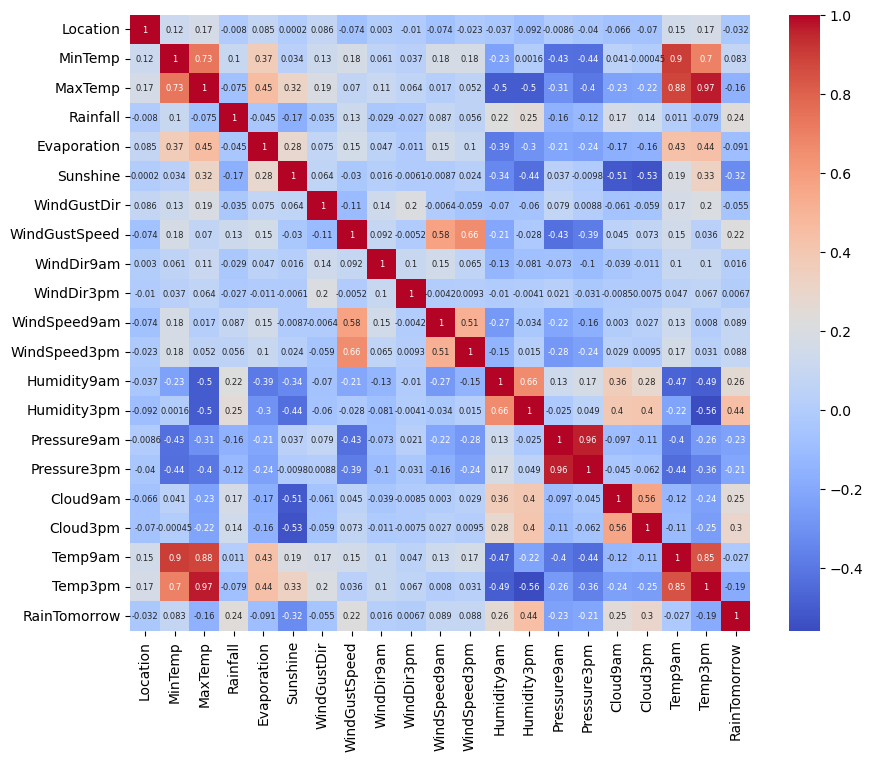

In [13]:
correlation_matrix = data.corr()
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", annot_kws= {'size': 6})
plt.show()

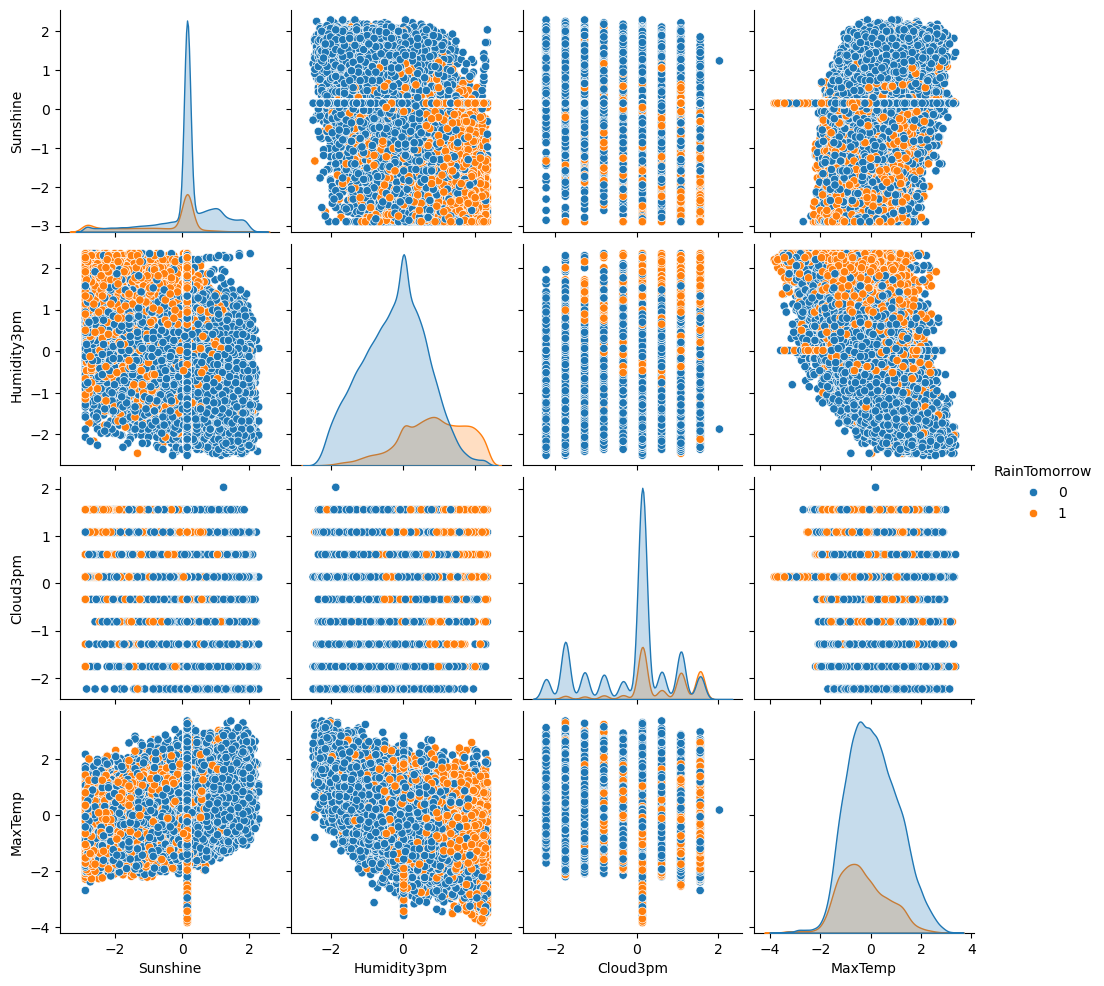

In [18]:
selected_data = data[['Sunshine', 'Humidity3pm', 'Cloud3pm', 'MaxTemp', 'RainTomorrow']]
sns.pairplot(selected_data, hue = "RainTomorrow")
plt.show()

## Part 3: Train a Classifier

Now that you've explored your data, your final task is to fit at least one of the classifers from the class so far (i.e. `Logisitic Regression`, `SVC`, or `KNeighborsClassifier`) on this task. Report it's precision, recall, and F$_1$ score using the code snippet at the bottom. 

In [29]:
def fit_predict(train_fname: str, test_fname: str) -> np.array: 
    """ Fit a logistic regression model and return its predictions on test data 

    Args:
        train_fname (str): Name of the training file 
        test_fname (str): Name of the testing file
    Returns:
        np.array: Predictions of the model on test data

    Note: 
        Make sure you preprocess both your train and test data!"""
    train = preprocess(train_fname)
    x_train = train.drop('RainTomorrow', axis = 1)
    y_train = train['RainTomorrow']
    test = preprocess(test_fname)
    x_test = test.drop('RainTomorrow', axis = 1)
    model = LogisticRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return y_pred


The following function can be used to get the precision, recall, and F$_1$ score from our model.

In [34]:
def score(test_fname: str, Y_pred: np.array) -> list[float]:
    test = preprocess(test_fname)
    Y = test[test.columns[test.columns.isin(['RainTomorrow'])]]

    precision = metrics.precision_score(Y, Y_pred)
    recall = metrics.recall_score(Y, Y_pred)
    f1 = metrics.f1_score(Y, Y_pred)

    return precision, recall, f1
    
Y_pred = fit_predict('Lab3_train.csv', 'Lab3_valid.csv')
print(score('Lab3_valid.csv', Y_pred))

(0.7138310185185185, 0.4885148514851485, 0.5800611333176581)


Not great, I bet isolating certain metrics would make the model run better, or using a different method.

In [45]:
def fit_predict2(train_fname: str, test_fname: str) -> np.array: 
    """ Fit a logistic regression model and return its predictions on test data 

    Args:
        train_fname (str): Name of the training file 
        test_fname (str): Name of the testing file
    Returns:
        np.array: Predictions of the model on test data

    Note: 
        Make sure you preprocess both your train and test data!"""
    train = preprocess(train_fname)
    x_train = train.drop('RainTomorrow', axis = 1)
    y_train = train['RainTomorrow']
    test = preprocess(test_fname)
    x_test = test.drop('RainTomorrow', axis = 1)
    model = KNeighborsClassifier(n_neighbors = 25)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return y_pred


In [46]:
Y_pred2 = fit_predict2('Lab3_train.csv', 'Lab3_valid.csv')
print(score('Lab3_valid.csv', Y_pred2))

(0.7363760217983651, 0.4281188118811881, 0.5414475331830704)


Not much better. Certainly something to think about for the upcoming homework...